In [1]:
from enum import Enum
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
%matplotlib inline
# Read in Seattle and Boston Data
def read_airbnb_data(dirname):
    df_listings = pd.read_csv(dirname + '/listings.csv')
    df_calendar = pd.read_csv(dirname + '/calendar.csv')
    df_reviews = pd.read_csv(dirname + '/reviews.csv')
    return df_listings, df_calendar, df_reviews

df_seattle_listings, df_seattle_calendar, df_seattle_reviews = read_airbnb_data('seattle')
df_boston_listings, df_boston_calendar, df_boston_reviews = read_airbnb_data('boston')

In [2]:
# Borrowed function used in example to process categorical fields
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

def process_boolean_fields(df,columns):
    for col in columns:
        df.loc[(df[col] == 't'),col]=1
        df.loc[(df[col] == 'f'),col]=0
        df.astype({col: 'int32'}).dtypes
    return df

def process_currency_fields(df,columns):
    for col in columns:
        df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)
    return df

def process_categorical_fields(df,columns):
    df = create_dummy_df(df, columns, False)
    return df

def process_features(df_listings,feature_numeric_fields,feature_boolean_fields,feature_categorical_fields,show_diagnostics=False):
    df_listings = df_listings.dropna(subset=feature_categorical_fields, how='any', axis=0)
    df_listings = df_listings.dropna(subset=feature_numeric_fields, how='any', axis=0)
    df_listings = df_listings.dropna(subset=feature_boolean_fields, how='any', axis=0)
    
    feature_columns=feature_numeric_fields    
    for field in feature_categorical_fields:
        feature_columns.append(field)       
    for field in feature_boolean_fields:
        feature_columns.append(field)
    feature_columns.append('price')    
    
    df_listings=df_listings[feature_columns]
    df_listings=process_currency_fields(df_listings,feature_currency_fields)
    df_listings=process_categorical_fields(df_listings,feature_categorical_fields) 
    df_listings=process_boolean_fields(df_listings,feature_boolean_fields) 
    
    print('feature vector dimensions={}'.format(df_listings.shape))
    return df_listings

def show_fraction_of_nulls(df_listings):
    print('fraction of neighbourhood_cleansed={}'.format(df_listings['neighbourhood_cleansed'].isnull().mean()))
    print('fraction of zipcode={}'.format(df_listings['zipcode'].isnull().mean()))
    
    print('fraction of property_type={}'.format(df_listings['property_type'].isnull().mean()))
    print('fraction of room_type={}'.format(df_listings['room_type'].isnull().mean()))
    
    print('fraction of bed_type={}'.format(df_listings['bed_type'].isnull().mean()))
    print('fraction of cancellation_policy={}'.format(df_listings['cancellation_policy'].isnull().mean()))
    
    print('fraction of review_scores_location={}'.format(df_listings['review_scores_location'].isnull().mean()))
    print('fraction of review_scores_rating={}'.format(df_listings['review_scores_rating'].isnull().mean()))
    print('fraction of reviews_per_month={}'.format(df_listings['reviews_per_month'].isnull().mean()))
    
    print('fraction of host is superhost={}'.format(df_listings['host_is_superhost'].isnull().mean()))
    print('fraction of require guess profile picture={}'.format(df_listings['require_guest_profile_picture'].isnull().mean()))
    print('fraction of require_guest_phone_verification={}'.format(df_listings['require_guest_phone_verification'].isnull().mean()))
    return

def show_correlation_plot(df_listings):
    fields_of_interest=['price','security_deposit','cleaning_fee','extra_people','accommodates','bathrooms','bedrooms','beds','guests_included','review_scores_location','review_scores_rating', \
            'review_scores_accuracy','review_scores_cleanliness','review_scores_value','review_scores_communication', \
            'reviews_per_month','host_total_listings_count','host_is_superhost','require_guest_profile_picture', 'host_has_profile_pic' , 'host_identity_verified', \
            'require_guest_phone_verification','availability_30','availability_60','availability_90','availability_365']
    
    df_corr=df_listings[fields_of_interest]
    df_corr = df_corr.dropna(subset=['host_is_superhost'], how='any', axis=0)
    df_corr=process_currency_fields(df_corr,['price','security_deposit','cleaning_fee','extra_people'])
    df_corr=process_boolean_fields(df_corr,['host_is_superhost','require_guest_profile_picture','require_guest_phone_verification', 'host_has_profile_pic' , 'host_identity_verified'])
    print('Mean require guest_profile={}'.format(df_corr['require_guest_profile_picture'].mean()))
    fig, ax = plt.subplots(figsize=(20,20)) 
    sns.heatmap(df_corr.corr(), annot = True,square=False, fmt='.1g')
    fig.savefig('correlation.png')
    return

def create_and_save_bar_plot(df_data,x_col_name,y_col_name,title,xlabel,ylabel,filename,xsize=15,ysize=15):
    fig=plt.figure(figsize=(xsize,ysize))
    plt.bar(df_data[x_col_name],df_data[y_col_name])
    plt.title(title)
    plt.xticks(df_data[x_col_name], df_data[x_col_name],rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)   
    plt.show()
    fig.savefig(filename,bbox_inches='tight')
    return
    
def create_and_save_line_plot(df_data,x_col_name,y_col_name,title,xlabel,ylabel,filename):
    fig=plt.figure(figsize=(9,6))
    plt.plot(df_data[x_col_name],df_data[y_col_name])
    plt.title(title)
    plt.xticks(df_data[x_col_name], df_data[x_col_name],rotation=90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)   
    plt.show()
    fig.savefig(filename,bbox_inches='tight')
    return

def show_price_histogram(data,plot_name,file_name):
    bin_range = np.arange(0.0,1050.0,50.0,dtype=np.float32)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    ax.text(300,1200,"Mean=\$128.0  stddev=\$90.0",fontsize=12)
    plt.hist(data,bin_range)
    plt.title(plot_name)
    plt.ylabel('Num Listings')
    plt.xlabel('Listing Price ($)')
    plt.xticks(bin_range)
    plt.xlim(0.0,1000.0)
    plt.show()
    fig.savefig(file_name)
    return

def group_calendar_by_month_year(df_calendar):
    df_available_calendar = df_calendar[df_calendar['available'] == 't']
    
    df_available_calendar['month'] = pd.DatetimeIndex(df_available_calendar['date']).month
    df_available_calendar['year'] = pd.DatetimeIndex(df_available_calendar['date']).year   

    df_available_calendar=process_currency_fields(df_available_calendar,['price'])
    
    df_calendar_grouped_by_month=df_available_calendar.groupby(['listing_id','month'])['price'].mean().reset_index(name="price")
    df_calendar_grouped_by_year=df_available_calendar.groupby(['listing_id','year'])['price'].mean().reset_index(name="price")
    return df_calendar_grouped_by_month, df_calendar_grouped_by_year

def show_month_years(df_calendar):   
    df_calendar_grouped_by_month, df_calendar_grouped_by_year=group_calendar_by_month_year(df_calendar)
    
    df_monthly=df_calendar_grouped_by_month.groupby('month')['price'].mean().reset_index(name="avg_price")

    df_yearly=df_calendar_grouped_by_year.groupby('year')['price'].mean().reset_index(name="avg_price")
    
    months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    df_monthly['month_name'] = months 
    
    create_and_save_line_plot(df_monthly,'month_name','avg_price','Seattle AirBnB Avg Listing Price by Month','Month','Price ($)','avg_price_by_month.png')
    create_and_save_bar_plot(df_yearly,'year','avg_price','Seattle AirBnB Avg Listing Price by Year','Year','Price ($)','avg_price_by_year.png',5,5)
    return
 
def show_location_data(df_listings):
    df_listings = df_listings.dropna(subset=['zipcode','neighbourhood_cleansed'], how='any', axis=0)
# drop a bad zipcode row that contains a newline in it and starts with 99
    df_listings = df_listings.drop(df_listings[df_listings['zipcode'].str.contains('\\n')].index)   
    df_num_listings_zip=df_listings.groupby('zipcode')['id'].count().reset_index(name="num_listings").sort_values(by='num_listings',ascending=False)
    
    create_and_save_bar_plot(df_num_listings_zip,'zipcode','num_listings','Seattle AirBnB Number of Listings by Zipcode','zipcode','Number of Listings','listings_per_zipcode.png')    
  
    df_listings['price'] = df_listings['price'].replace('[\$,]', '', regex=True).astype(float)
    
    df_price_by_neighborhoods=df_listings.groupby('neighbourhood_cleansed')['price'].mean().reset_index(name="mean_price").sort_values(by='mean_price',ascending=False)
    create_and_save_bar_plot(df_price_by_neighborhoods,'neighbourhood_cleansed','mean_price','Seattle AirBnB Avg Price by Neighborhood','Neighborhood','Avg Price','price_per_neighborhood.png')    
    print(df_price_by_neighborhoods)
    
    df_price_by_zipcodes=df_listings.groupby('zipcode')['price'].mean().reset_index(name="mean_price").sort_values(by='mean_price',ascending=False)
    create_and_save_bar_plot(df_price_by_zipcodes,'zipcode','mean_price','Seattle AirBnB Avg Price by Zipcode','Zipcode','Avg Price','price_per_zipcode.png')    
    print(df_price_by_zipcodes)
    
    df_price_by_neighborhood_and_zipcodes=df_listings.groupby(['neighbourhood_cleansed','zipcode'])['price'].mean().reset_index(name="mean_price").sort_values(by='mean_price',ascending=False)
    df_price_by_neighborhood_and_zipcodes['combined_name']=df_price_by_neighborhood_and_zipcodes['neighbourhood_cleansed'] + '/' + df_price_by_neighborhood_and_zipcodes['zipcode']
    create_and_save_bar_plot(df_price_by_neighborhood_and_zipcodes.iloc[0:50,:],'combined_name','mean_price','Seattle AirBnB Avg Price by Neighborhood/Zipcode','Neighborhood/Zipcode','Avg Price','price_per_neighborhood_zipcode.png')    
    print(df_price_by_neighborhood_and_zipcodes)
    return

def show_visualizations(df_listings,df_calendar):
    show_fraction_of_nulls(df_listings)
    show_correlation_plot(df_listings)
    df_prices = process_currency_fields(df_listings,['price'])['price']
    show_price_histogram(df_prices,'Seattle AirBnB Listing Prices','price_histogram.png')    
    show_month_years(df_calendar)
    show_location_data(df_listings)
    return

def visualize_results(str_algorithm,y_test,y_test_preds,y_train,y_train_preds):
    str_title='Prediction Error for ' + str_algorithm + ' Algorithm ({}'.format(len(y_test)) + ' Data Points)'
    
    plt.scatter(y_train_preds,  y_train_preds - y_train,
            color='lightgreen', marker='o', label='Training data')
    plt.scatter(y_test_preds,  y_test_preds - y_test,
            color='blue', marker='s', label='Test data')
    plt.title(str_title)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.show()
    
    bin_range = np.arange(0.0,200.0,10.0,dtype=np.float32)
    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)    
    arr = plt.hist(abs(y_test_preds - y_test),bin_range,color='blue') 
    your_bins=19
    
    for i in range(your_bins):
        plt.text(arr[1][i],arr[0][i],'{0:.0f}'.format(arr[0][i]))
    
    plt.title(str_title)
    plt.ylabel('Number of Data Points')
    plt.xlabel('abs(prediction - actual)')
    plt.xticks(bin_range)
     
    plt.show()
    filename=str_algorithm.lower()+'.png'
    fig.savefig(filename)
    return

fraction of neighbourhood_cleansed=0.0
fraction of zipcode=0.0018334206390780514
fraction of property_type=0.00026191723415400735
fraction of room_type=0.0
fraction of bed_type=0.0
fraction of cancellation_policy=0.0
fraction of review_scores_location=0.1715557883708748
fraction of review_scores_rating=0.16946045049764275
fraction of reviews_per_month=0.1642221058145626
fraction of host is superhost=0.0005238344683080147
fraction of require guess profile picture=0.0
fraction of require_guest_phone_verification=0.0
Mean require guest_profile=0.08411949685534591


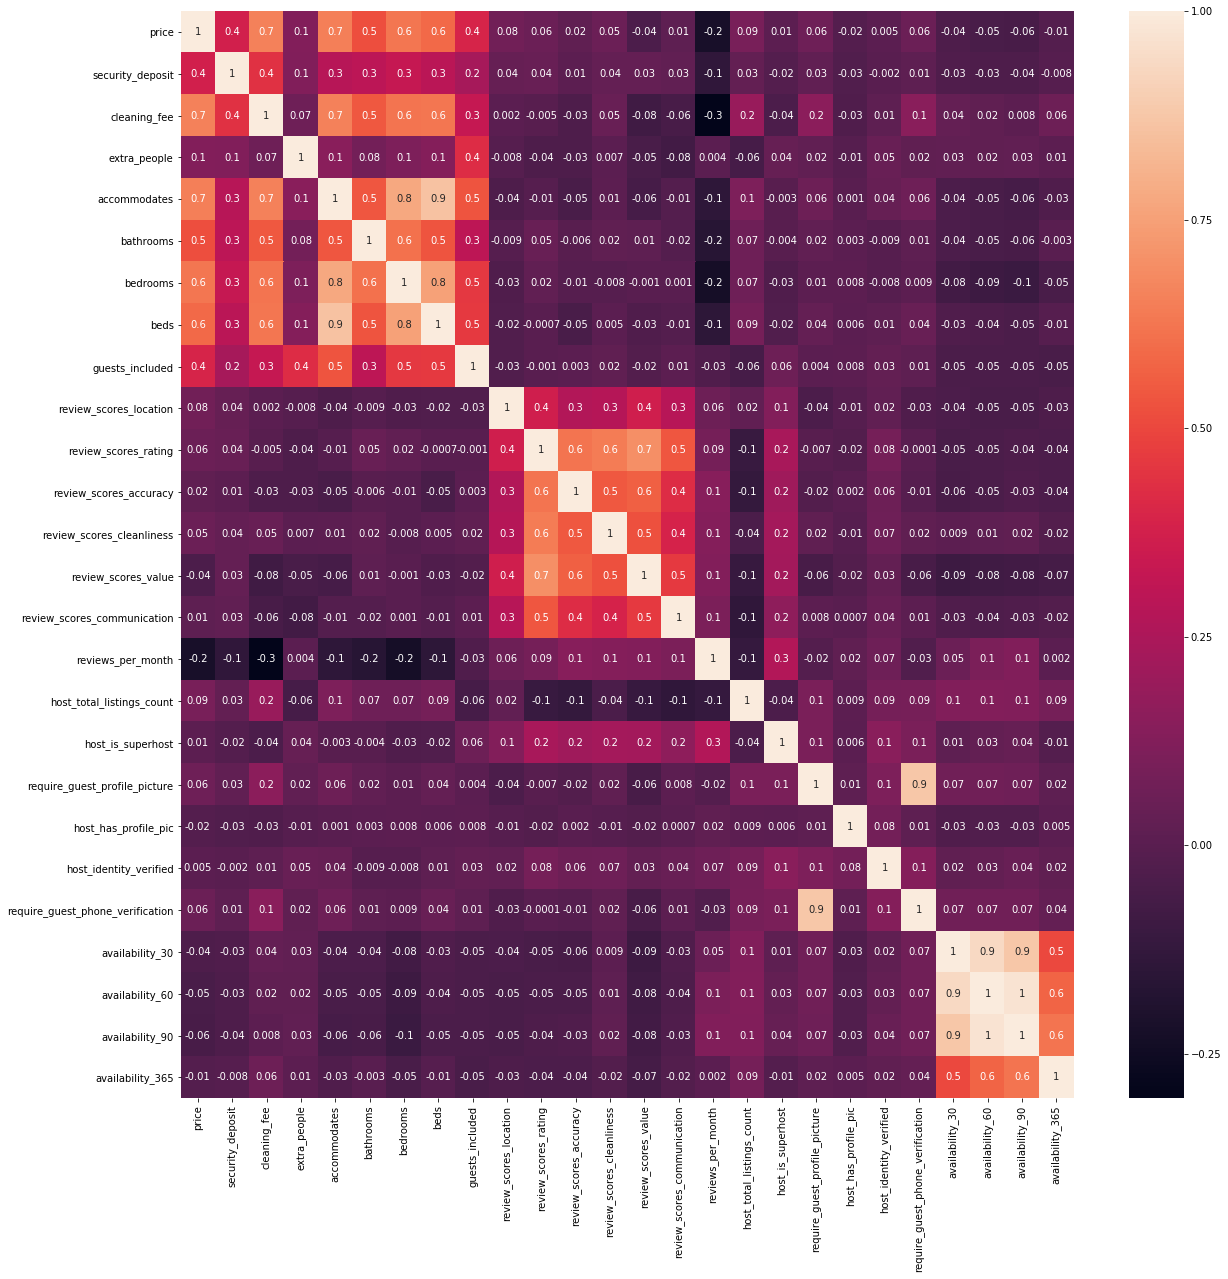

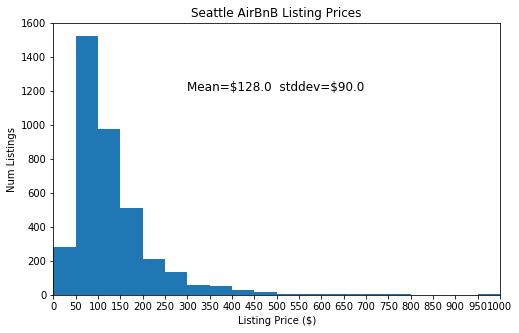

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

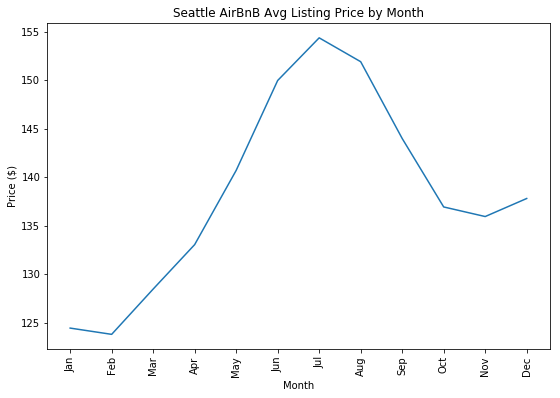

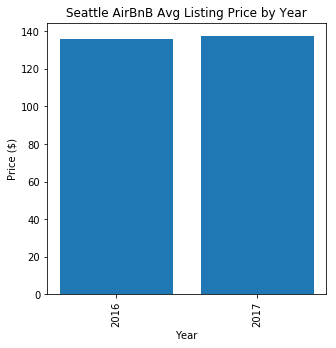

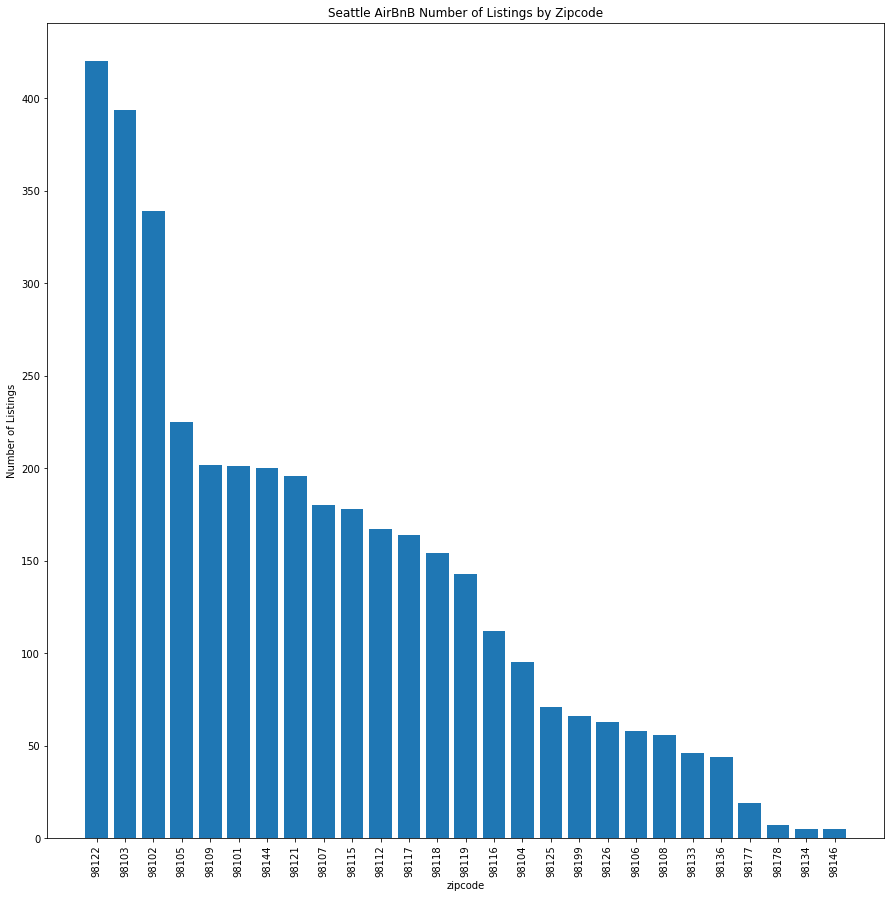

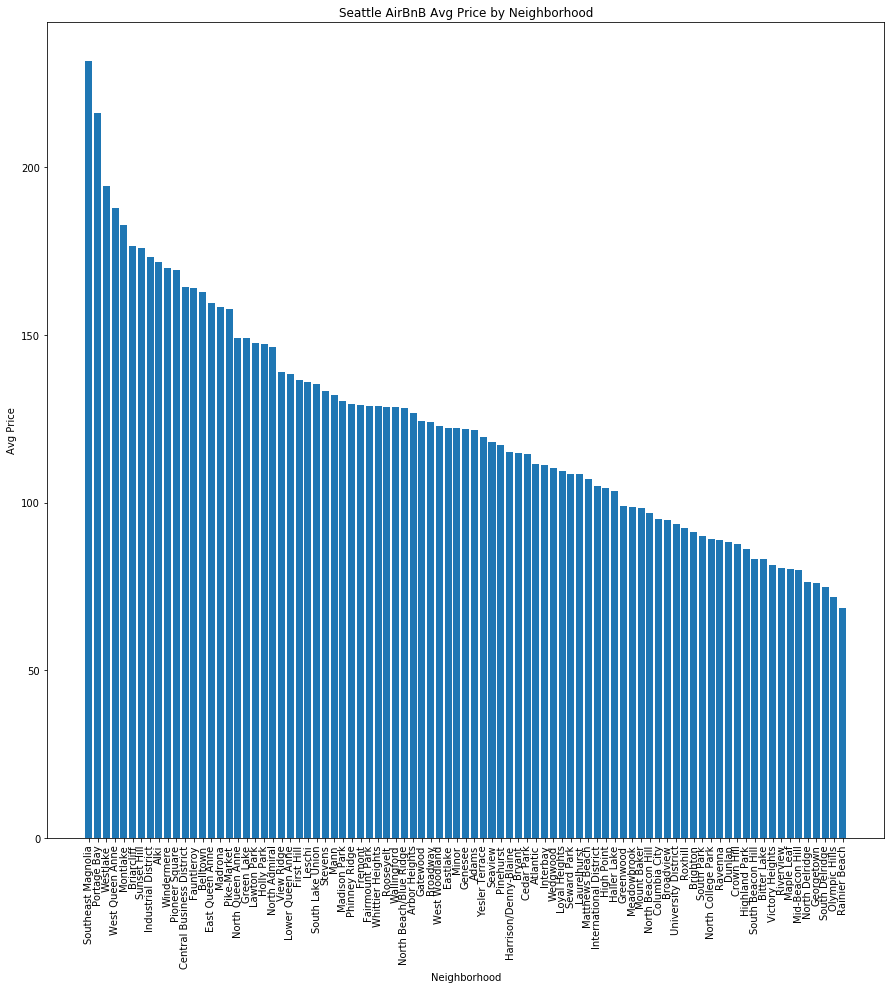

       neighbourhood_cleansed  mean_price
73         Southeast Magnolia  231.705882
61                Portage Bay  216.153846
83                   Westlake  194.470588
81            West Queen Anne  187.769231
48                   Montlake  182.789474
6                  Briarcliff  176.571429
75                Sunset Hill  176.055556
32        Industrial District  173.333333
1                        Alki  171.619048
85                 Windermere  169.900000
60             Pioneer Square  169.260870
12  Central Business District  164.213592
19                 Fauntleroy  164.100000
4                    Belltown  162.893162
16            East Queen Anne  159.414634
41                    Madrona  158.234043
58                Pike-Market  157.785714
55           North Queen Anne  149.132075
25                 Green Lake  149.018519
36                Lawton Park  147.566667
31                 Holly Park  147.166667
50              North Admiral  146.408163
78                 View Ridge  139

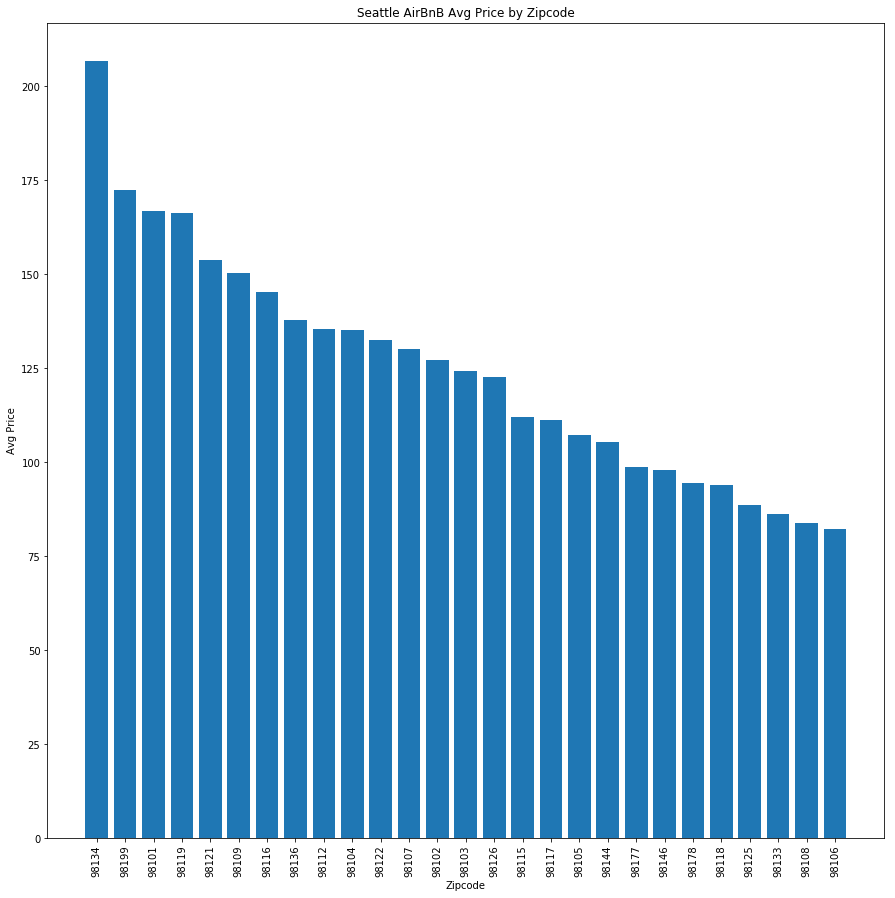

   zipcode  mean_price
20   98134  206.600000
26   98199  172.393939
0    98101  166.721393
14   98119  166.377622
15   98121  153.785714
8    98109  150.247525
11   98116  145.348214
21   98136  137.909091
9    98112  135.437126
3    98104  135.221053
16   98122  132.492857
6    98107  130.238889
1    98102  127.103245
2    98103  124.149746
18   98126  122.730159
10   98115  112.129213
12   98117  111.262195
4    98105  107.111111
22   98144  105.395000
24   98177   98.842105
23   98146   97.800000
25   98178   94.428571
13   98118   93.798701
17   98125   88.577465
19   98133   86.282609
7    98108   83.875000
5    98106   82.103448


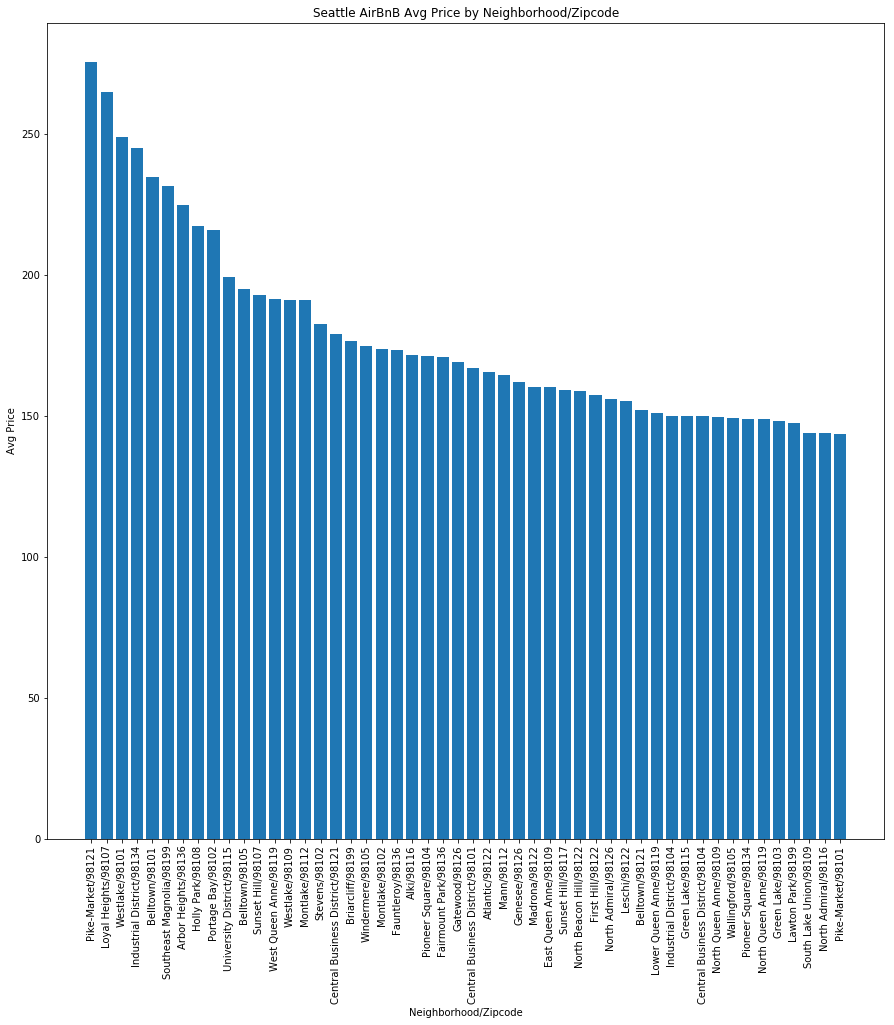

        neighbourhood_cleansed zipcode  mean_price  \
124                Pike-Market   98121  275.666667   
84               Loyal Heights   98107  265.000000   
166                   Westlake   98101  249.000000   
73         Industrial District   98134  245.000000   
7                     Belltown   98101  234.687500   
146         Southeast Magnolia   98199  231.705882   
3                Arbor Heights   98136  225.000000   
68                  Holly Park   98108  217.500000   
128                Portage Bay   98102  216.153846   
154        University District   98115  199.333333   
9                     Belltown   98105  195.000000   
150                Sunset Hill   98107  192.777778   
163            West Queen Anne   98119  191.693548   
167                   Westlake   98109  191.062500   
103                   Montlake   98112  191.000000   
147                    Stevens   98102  182.500000   
29   Central Business District   98121  179.000000   
14                  Briarcli

In [3]:
# Generate all the visualizations needed
show_visualizations(df_seattle_listings,df_seattle_calendar)

In [4]:
# feature engineering
feature_boolean_fields=['host_is_superhost','require_guest_profile_picture','require_guest_phone_verification']
feature_currency_fields=['price']

#feature_numeric_fields=['accommodates','bathrooms','bedrooms','beds','guests_included','review_scores_location','review_scores_rating','reviews_per_month']
feature_numeric_fields=['accommodates','bathrooms','bedrooms','beds','guests_included','review_scores_rating']
#feature_categorical_fields=['zipcode','neighbourhood_cleansed','property_type','room_type','bed_type','cancellation_policy']
feature_categorical_fields=['zipcode','neighbourhood_cleansed','property_type','room_type','bed_type']
df_cleaned_listings = df_seattle_listings.dropna(subset=['zipcode'], how='any', axis=0)
df_cleaned_listings = df_cleaned_listings.drop(df_cleaned_listings[df_cleaned_listings['zipcode'].str.contains('\\n')].index)

df_cleaned_listings=df_cleaned_listings.rename(columns={"price": "listing_price"})

df_calendar_grouped_by_month, df_calendar_grouped_by_year=group_calendar_by_month_year(df_seattle_calendar)
df_cleaned_listings=df_cleaned_listings.join(df_calendar_grouped_by_month.set_index('listing_id'), on='id')

feature_numeric_fields.append('month')

X=process_features(df_cleaned_listings,feature_numeric_fields,feature_boolean_fields,feature_categorical_fields)
y=X['price']

X=X.drop(['price'], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

feature vector dimensions=(28441, 144)


In [5]:
class Algorithm(Enum):
        LINEAR_REGRESSION = 1
        RIDGE=2
        DECISION_TREE_REGRESSOR=3
        LASSO=4
        ELASTICNET = 5
        BAYESIAN_RIDGE = 6
        SGD_REGRESSOR = 7
        RANDOM_FOREST_REGRESSOR = 8

def train_and_evaluate(algo,X_train, X_test, y_train, y_test,do_visualization=True):
    if (algo.value==Algorithm.RANDOM_FOREST_REGRESSOR.value):
        lm_model=ensemble.RandomForestRegressor(n_estimators=350,criterion='mse',random_state=21,n_jobs=-1)
    elif (algo.value==Algorithm.LINEAR_REGRESSION.value):
        lm_model = linear_model.LinearRegression(normalize=True)
    elif (algo.value==Algorithm.RIDGE.value):
        lm_model = linear_model.Ridge(alpha=.5)
    elif (algo.value==Algorithm.DECISION_TREE_REGRESSOR.value):
        lm_model = tree.DecisionTreeRegressor()
    elif (algo.value==Algorithm.LASSO.value):
        lm_model = linear_model.Lasso(alpha=0.1)
    elif (algo.value==Algorithm.ELASTICNET.value):
        lm_model = linear_model.ElasticNet(alpha=0.01)
    elif (algo.value==Algorithm.BAYESIAN_RIDGE.value):
        lm_model = linear_model.BayesianRidge()
    elif (algo.value==Algorithm.SGD_REGRESSOR.value):
        lm_model = linear_model.SGDRegressor(max_iter=1500,tol=0.01)
    else:  
        lm_model=ensemble.RandomForestRegressor(n_estimators=350,criterion='mse',random_state=21,n_jobs=-1)
# Fit the selected model
    lm_model.fit(X_train, y_train) 
# Predict and score the model 
    y_test_preds = lm_model.predict(X_test) 
    y_train_preds = lm_model.predict(X_train)
    
# Calculate the r2 score, MAE, and MSE for the training data
    r2_score_train=r2_score(y_train, y_train_preds)
    mae_train=mean_absolute_error(y_train, y_train_preds)
    mse_train=mean_squared_error(y_train, y_train_preds)
    
# Calculate the r2 score, MAE, and MSE for the test data
    r2_score_test=r2_score(y_test, y_test_preds)
    mae_test=mean_absolute_error(y_test, y_test_preds)
    mse_test=mean_squared_error(y_train, y_train_preds)
    
    if do_visualization:
        visualize_results(algo.name,y_test,y_test_preds,y_train,y_train_preds)
    
    return r2_score_test, mae_test, mse_test, r2_score_train, mae_train, mse_train

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state=42)

for alg in Algorithm:
    r2_score_test, mae_test, mse_test, r2_score_train, mae_train, mse_train=train_and_evaluate( \
                                            alg,X_train,X_test,y_train,y_test,False)
    print('Algorithm: {}'.format(alg.name))
    s_train='TRAINING: r-squared={:.3f}, mae={:.3f}, mse={:.3f} on {} values.'.format(r2_score_train, mae_train, mse_train, len(y_train)) 
    print(s_train) 
    s_test='TESTING: r-squared={:.3f}, mae={:.3f}, mse={:.3f} on {} values.'.format(r2_score_test, mae_test, mse_test, len(y_test)) 
    print(s_test)  
    print('------------------------------------------------------------')

Algorithm: LINEAR_REGRESSION
TRAINING: r-squared=0.658, mae=37.962, mse=3767.693 on 25596 values.
TESTING: r-squared=0.643, mae=38.420, mse=3767.693 on 2845 values.
------------------------------------------------------------
Algorithm: RIDGE
TRAINING: r-squared=0.658, mae=37.949, mse=3767.854 on 25596 values.
TESTING: r-squared=0.642, mae=38.404, mse=3767.854 on 2845 values.
------------------------------------------------------------
Algorithm: DECISION_TREE_REGRESSOR
TRAINING: r-squared=0.998, mae=0.772, mse=23.957 on 25596 values.
TESTING: r-squared=0.961, mae=7.425, mse=23.957 on 2845 values.
------------------------------------------------------------
Algorithm: LASSO
TRAINING: r-squared=0.646, mae=37.919, mse=3893.200 on 25596 values.
TESTING: r-squared=0.629, mae=38.208, mse=3893.200 on 2845 values.
------------------------------------------------------------
Algorithm: ELASTICNET
TRAINING: r-squared=0.644, mae=37.786, mse=3916.828 on 25596 values.
TESTING: r-squared=0.623, mae